In [1]:
%load_ext autoreload
%autoreload 2
import os 
os.chdir("/home/jadli/Bureau/BDAI2/Satellite_Super_Resulotion0")


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
from src.utils.data_fetcher import create_loaders
from src.utils.models_architecture import EDSR
from src.utils.helper_functions import train_sr, val_sr, plot_sr_progress
import os
import json

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device : {device}")

device : cuda


In [3]:
model = EDSR().to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4
)


In [4]:
from PIL import Image
import torchvision.transforms as T

hr_path="./data/preprocessed/test/HR/austin1_r07_c09.png"
lr_path="./data/preprocessed/test/LR/austin1_r07_c09.png"

lr_img = Image.open(lr_path).convert("RGB")
hr_img = Image.open(hr_path).convert("RGB")


In [5]:
assert hr_img.size[0] == lr_img.size[0] * 4
assert hr_img.size[1] == lr_img.size[1] * 4


In [6]:
to_tensor = T.ToTensor()

lr = to_tensor(lr_img).unsqueeze(0).to(device)  # [1,3,h,w]
hr = to_tensor(hr_img).unsqueeze(0).to(device)  # [1,3,H,W]


In [7]:
sr = model(lr)
print(sr.shape, hr.shape)


torch.Size([1, 3, 192, 192]) torch.Size([1, 3, 192, 192])


In [8]:
import math


def compute_psnr(sr, hr, max_val=1.0):
    mse = torch.mean((sr - hr) ** 2)
    if mse == 0:
        return 100.0
    psnr = 10 * torch.log10((max_val ** 2) / mse)
    return psnr.item()

def compute_psnr2(sr, hr):
    """
    Compute PSNR (Peak Signal-to-Noise Ratio)
    """
    mse = F.mse_loss(sr, hr)
    if mse == 0:
        return 100
    return 10 * math.log10(1.0 / mse.item())

In [9]:
from torch.amp import autocast, GradScaler

model.train()
scaler = GradScaler()

num_iters = 10000  # iterations, NOT epochs

for i in range(num_iters):
    optimizer.zero_grad()

    with autocast(device_type="cuda"):
        sr = model(lr)       # SRResNet upsamples internally
        loss = criterion(sr, hr)

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    if i % 100 == 0:
        psnr = 10 * torch.log10(1.0 / loss).item()
        print(f"Iter {i:04d} | Loss: {loss.item():.6f} | PSNR: {psnr:.2f} dB")


Iter 0000 | Loss: 0.371404 | PSNR: 4.30 dB
Iter 0100 | Loss: 0.063868 | PSNR: 11.95 dB
Iter 0200 | Loss: 0.049741 | PSNR: 13.03 dB
Iter 0300 | Loss: 0.045444 | PSNR: 13.43 dB
Iter 0400 | Loss: 0.042761 | PSNR: 13.69 dB
Iter 0500 | Loss: 0.041296 | PSNR: 13.84 dB
Iter 0600 | Loss: 0.040589 | PSNR: 13.92 dB
Iter 0700 | Loss: 0.039556 | PSNR: 14.03 dB
Iter 0800 | Loss: 0.038747 | PSNR: 14.12 dB
Iter 0900 | Loss: 0.038026 | PSNR: 14.20 dB
Iter 1000 | Loss: 0.036963 | PSNR: 14.32 dB
Iter 1100 | Loss: 0.036069 | PSNR: 14.43 dB
Iter 1200 | Loss: 0.034814 | PSNR: 14.58 dB
Iter 1300 | Loss: 0.033721 | PSNR: 14.72 dB
Iter 1400 | Loss: 0.032063 | PSNR: 14.94 dB
Iter 1500 | Loss: 0.030398 | PSNR: 15.17 dB
Iter 1600 | Loss: 0.028841 | PSNR: 15.40 dB
Iter 1700 | Loss: 0.027806 | PSNR: 15.56 dB
Iter 1800 | Loss: 0.025825 | PSNR: 15.88 dB
Iter 1900 | Loss: 0.024747 | PSNR: 16.06 dB
Iter 2000 | Loss: 0.023728 | PSNR: 16.25 dB
Iter 2100 | Loss: 0.022844 | PSNR: 16.41 dB
Iter 2200 | Loss: 0.021734 | PSNR

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1213261..1.0092711].


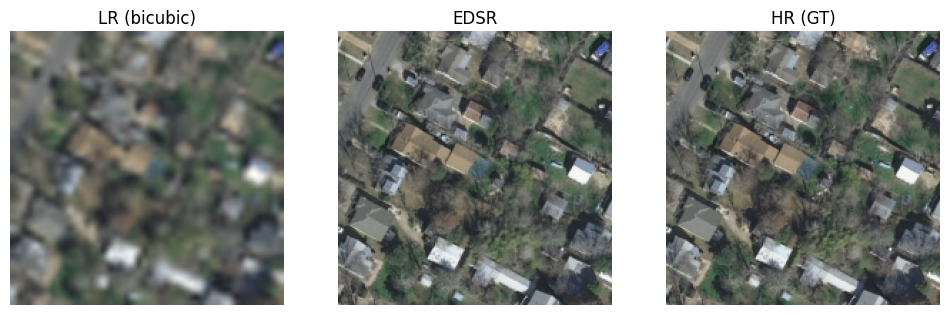

In [12]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    sr = model(lr).clamp(0, 1)

sr_img = sr.squeeze(0).permute(1, 2, 0).cpu()
hr_img = hr.squeeze(0).permute(1, 2, 0).cpu()
lr_up = torch.nn.functional.interpolate(
    lr, scale_factor=4, mode="bicubic", align_corners=False
)
lr_up = lr_up.squeeze(0).permute(1, 2, 0).cpu()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("LR (bicubic)"); plt.imshow(lr_up); plt.axis("off")
plt.subplot(1,3,2); plt.title("EDSR"); plt.imshow(sr_img); plt.axis("off")
plt.subplot(1,3,3); plt.title("HR (GT)"); plt.imshow(hr_img); plt.axis("off")
plt.show()


In [13]:
with torch.no_grad():
    sr = model(lr).clamp(0, 1)

psnr = compute_psnr(sr, hr)
print(f"PSNR: {psnr:.2f} dB")

psnr2 = compute_psnr2(sr, hr)
print(f"PSNR: {psnr2:.2f} dB")



PSNR: 41.97 dB
PSNR: 41.97 dB
